# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.shape

(7591, 2)

Text(0.5, 1.0, 'График распредления объектов по возрастам')

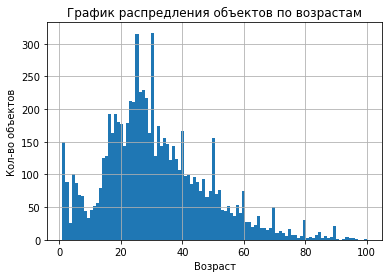

In [4]:
labels.hist(bins=100)
plt.xlabel('Возраст')
plt.ylabel('Кол-во объектов')
plt.title('График распредления объектов по возрастам')


In [5]:
display(labels.describe())

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


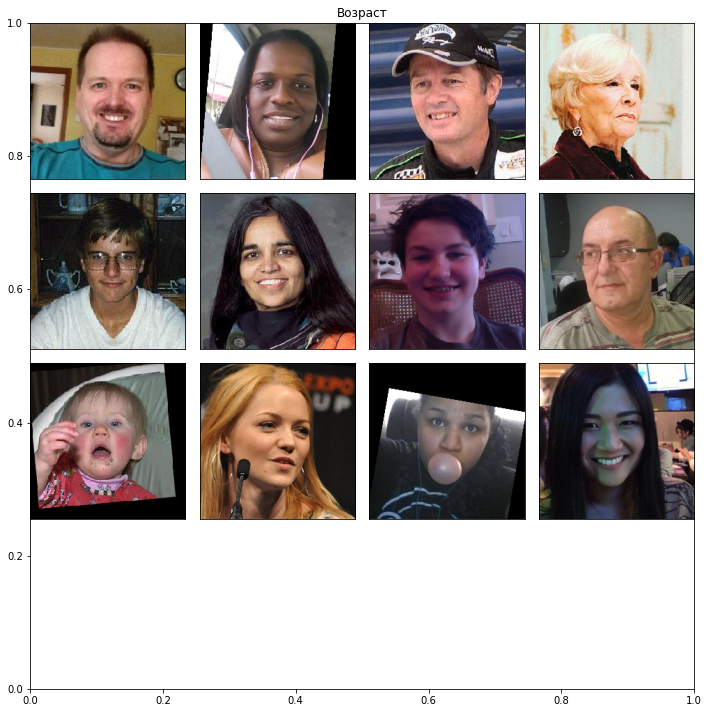

In [6]:
features, target = next(gen_flow)

fig = plt.figure(figsize=(10,10))
plt.title('Возраст')
# display('Возраст    :', labels.loc[i, 'real_age'])
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Предварительный итог

** В датафрейме всего 7591 объект, каждый из которых должен соответствовать файлу датасета. Подобного количества объектов должно быть достаточно для обучения нейросети, ранее обученной на большей выборке.

** В датафрейме 2 признака: file_name с именами файлов и целевой признак real_age с возрастами людей, изображенных в файлах. Целевой признак имеет целочисленные значения, где каждое число означает год.

** Наблюдаются отдельные всплески в значениях возрастов кратных 5. Это может свидетельствовать о возможном округлении целевых значений возрастов при их разметке. Это будет создавать помехи для предсказания точного возраста.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
import pandas as pd
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator




def load_train(path): 
    labels = pd.read_csv(path + 'labels.csv') 
    train_datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255) 
    train_gen_flow = train_datagen.flow_from_dataframe( 
        dataframe=labels, 
        directory=path + 'final_files/', 
        x_col='file_name', 
        y_col='real_age', 
        target_size=(224, 224), 
        batch_size=16, 
        class_mode='raw', 
        subset='training', 
        seed=12345)  
    return train_gen_flow



def load_test(path): 
    labels = pd.read_csv(path + 'labels.csv') 
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255) 
    test_gen_flow = test_datagen.flow_from_dataframe( 
        dataframe=labels, 
        directory=path + 'final_files/', 
        x_col='file_name', 
        y_col='real_age', 
        target_size=(224, 224), 
        batch_size=16, 
        class_mode='raw', 
        subset='validation', 
        seed=12345) 
    return test_gen_flow



def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                 include_top=False, weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_absolute_error',metrics=['mae'])

    return model




def train_model(model, train_data, test_data, batch_size=None,
                epochs=10, steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              epochs=epochs, verbose=2)

    return model
```

```
356/356 - 48s - loss: 10.7166 - mae: 10.7173 - val_loss: 20.8722 - val_mae: 20.8686
Epoch 2/10
356/356 - 39s - loss: 7.4811 - mae: 7.4817 - val_loss: 8.8615 - val_mae: 8.8545
Epoch 3/10
356/356 - 39s - loss: 6.6449 - mae: 6.6450 - val_loss: 6.5719 - val_mae: 6.5733
Epoch 4/10
356/356 - 39s - loss: 5.8946 - mae: 5.8951 - val_loss: 7.9948 - val_mae: 7.9841
Epoch 5/10
356/356 - 39s - loss: 5.4035 - mae: 5.4038 - val_loss: 6.8839 - val_mae: 6.8930
Epoch 6/10
356/356 - 39s - loss: 4.8814 - mae: 4.8815 - val_loss: 6.5741 - val_mae: 6.5690
Epoch 7/10
356/356 - 39s - loss: 4.4927 - mae: 4.4927 - val_loss: 6.5392 - val_mae: 6.5340
Epoch 8/10
356/356 - 39s - loss: 4.2488 - mae: 4.2487 - val_loss: 6.8424 - val_mae: 6.8394
Epoch 9/10
356/356 - 39s - loss: 3.9072 - mae: 3.9073 - val_loss: 5.9432 - val_mae: 5.9493
Epoch 10/10
356/356 - 39s - loss: 3.6234 - mae: 3.6233 - val_loss: 6.1843 - val_mae: 6.1833
WARNING:tensorflow:sample_weight modes were coerced from
    to  
  ...
  ['...']
119/119 - 10s - loss: 6.1843 - mae: 6.1833
```

## Анализ обученной модели

Обученная модель позволяет с высокой точностью предсказывать возраст покупателей. Получение значения МАЕ 5.3 - хороший показатель, так как для категорий пользователей погрешность в 5 лет не так страшна. В основном по причине , что категории покупателей по возрасту разделяют по 8-12 лет.

Использование GPU и нейронных сетей позволяет быстро и эффективно обработать большое количество информации с высокой точностью.

С точки зрения использования данной модели в реальном бизнесе получен не самый точный результат. Причина в использованном датасете. В нем фотографии людей в основном среднего возраста. Фотографий детей, особенно среднего школьного возраста, и людей приклонного возраста не достаточно для полноценного обучения модели. Если датасет с фотографиями дополнить объектами в тех возрастных категориях, где количества изображений относительно мало, то качество модели будет лучше. Также на качестве обучения сказалось возможное округление до 5 целевых значений в ряде случаем. Это возможно исправить только более качественной разметкой целевых признаков.

Данная модель рекоммендуется для использования в сервисе, анализирующем покупки и предлагающем товары, которые могут заинтересовать покупателей возрастной группы анализ. Модель не рекоммендуется длля контроля добросовестности кассиров при продаже алкоголя.

## Чек-лист


- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]   Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы